In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import glob
import cv2
import plotly.express as px


from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import UnidentifiedImageError
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW, SGD, RMSprop, Adadelta, Adam
from keras.utils import to_categorical

%matplotlib inline 

In [2]:
black_soil    = os.listdir('Dataset/Train/Black Soil/')
clay_soil     = os.listdir('Dataset/Train/Clay soil/')
red_soil      = os.listdir('Dataset/Train/Red soil/')

In [3]:
black, clay, red =  len(black_soil), len(clay_soil), len(red_soil)
e = black + clay + red
print("Total images: ", e)
class_names = [ 'Black soil', 'clay soil', 'red soil']
n_images = [black, clay, red]
px.pie(names=class_names, values=n_images)

Total images:  4588


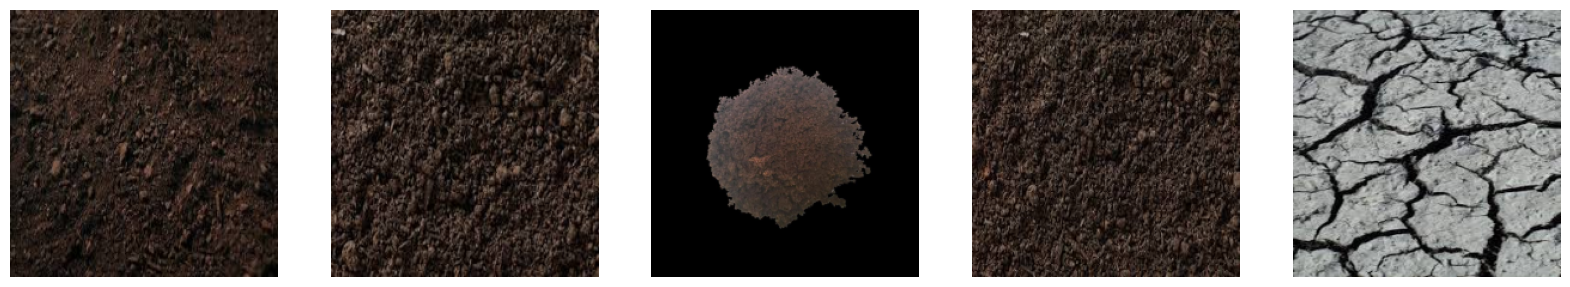

In [23]:
# black_soil review
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(black_soil)) 
    img  = imread('Dataset/Train/Black Soil/' + black_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

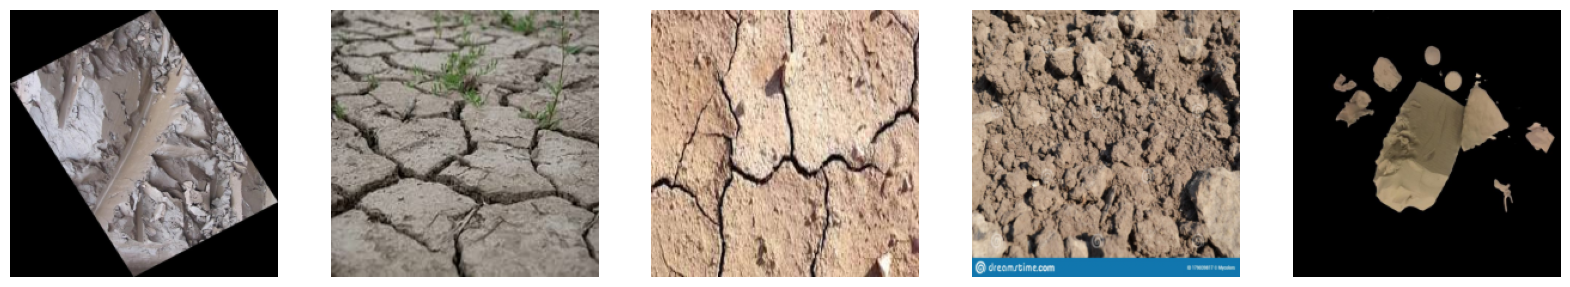

In [24]:
# clay review
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(clay_soil)) 
    img  = imread('Dataset/Train/Clay soil/' + clay_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

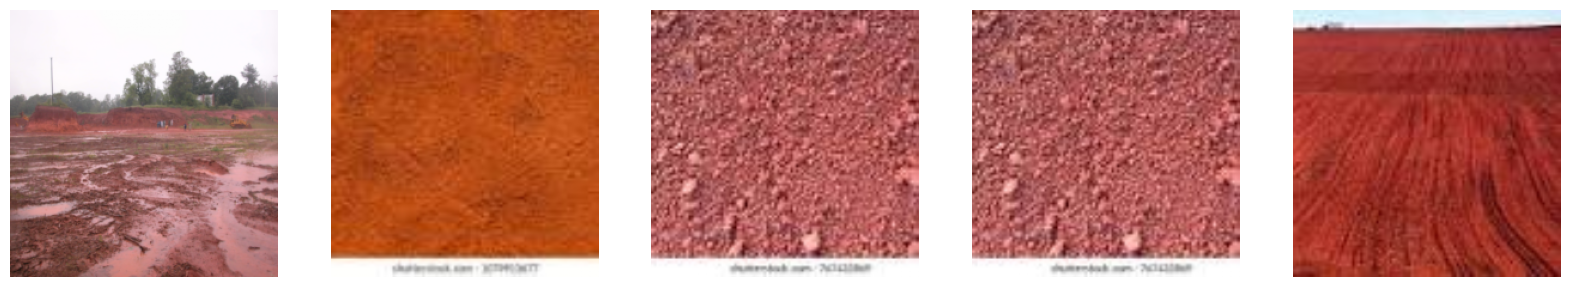

In [25]:
# red soil review
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(red_soil)) 
    img  = imread('Dataset/Train/Red soil/' + red_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

In [4]:

datagen  = ImageDataGenerator(rescale=1./255)


train_dataset = datagen.flow_from_directory(directory = 'Dataset/Train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_datset = datagen.flow_from_directory(directory = 'Dataset/test',
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               batch_size = 64)

vail_datset = datagen.flow_from_directory(directory = 'Dataset/Val',
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               batch_size = 64)




Found 4585 images belonging to 3 classes.
Found 236 images belonging to 3 classes.
Found 51 images belonging to 3 classes.


<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
[0. 0. 1.]


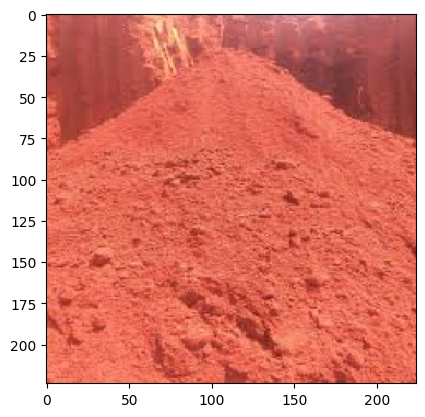

In [26]:
print(type(train_dataset))
X, y = train_dataset[12]
plt.imshow(X[0])
print(y[0])

In [5]:
model = Sequential()

#input
model.add(InputLayer(input_shape = (224,224,3)))

#block 1
model.add(Conv2D(32,  kernel_size  = (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

#block 2
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

#block 3
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

#block 4 - Flatten & Full Connected Layer
model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#output
model.add(Dense(3, activation = 'softmax'))


/Users/lehacho/Desktop/bauman/4sem/BigData(ML)/tensorflow-metal-test/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

2024-04-28 17:10:53.730135: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-28 17:10:53.730162: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-28 17:10:53.730171: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-28 17:10:53.730732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 17:10:53.730753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,755 (42.61 MB)

 Trainable params: 11,170,051 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

доп задание: 1.Реализуйте алгоритмы оптимизации: SGD и RMSprop.
2. Оцените производительность модели при использовании Adam, SGD и RMSprop - сравнение приведите в виде графиков точности (accuracy) для каждого модели и эпохи обучения

In [7]:
lr = 1e-5
optimizer = Adadelta(lr)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
filepath = 'result/.best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 25) # максимально кол-во эпох без улучшений - остановка обучения

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1) # сохранение промежуточных весов 

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  factor = 0.1,
                                  min_delta = 1e-5,
                                  patience = 5) # автоматическое уменьшение lr если метрики не улучшаются

callback_list = [earlystopping, checkpoint, learning_rate]

In [9]:
model_history = model.fit(train_dataset,
                          validation_data =vail_datset,
                          epochs = 100,
                          verbose = 1,
                          callbacks = callback_list)

Epoch 1/100


2024-04-28 17:11:15.911269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/lehacho/Desktop/bauman/4sem/BigData(ML)/tensorflow-metal-test/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.3575 - loss: 1.7202
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to result/.best_weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 682ms/step - accuracy: 0.3575 - loss: 1.7203 - val_accuracy: 0.3333 - val_loss: 1.1628 - learning_rate: 1.0000e-05
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3786 - loss: 1.6342
Epoch 2: val_accuracy did not improve from 0.33333
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 572ms/step - accuracy: 0.3786 - loss: 1.6338 - val_accuracy: 0.3333 - val_loss: 1.1431 - learning_rate: 1.0000e-05
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3868 - loss: 1.6142
Epoch 3: val_accuracy improved from 0.33333 to 0.37255, saving model to result/.best_weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 574ms/step - accuracy: 0.3867 - loss: 1.6138 - val_accuracy: 0.3725 - val_loss: 1.0288 - learning_rate: 1.0000e-05
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.

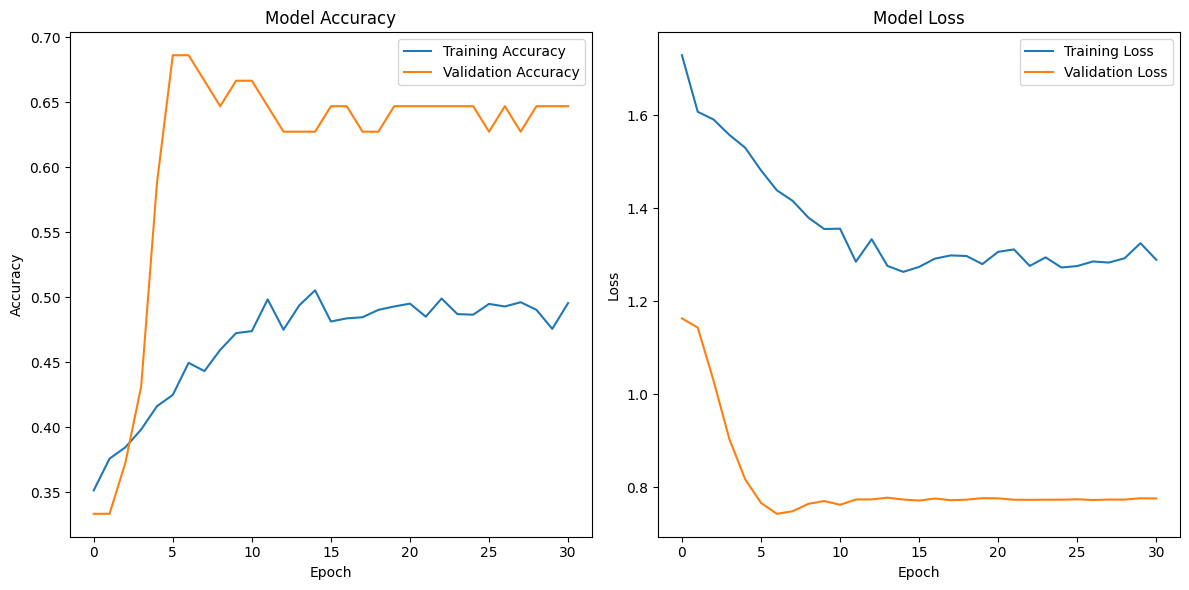

In [10]:
# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Построение графика потерь
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_loss, test_accuracy = model.evaluate(test_datset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.6389 - loss: 0.8145
Test Loss: 0.8260550498962402
Test Accuracy: 0.6271186470985413


In [14]:
save_dir = "./result/"
model_name = 'soil_rec_RMSprop_aug.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)


In [29]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)  # Добавляем размерность канала
    return image

def predict_image(model, image):
    image_batch = np.expand_dims(image, axis=0)
    print(image_batch.shape)
    prediction = model.predict(image_batch)
    return prediction

In [19]:
soil_model = load_model('./result/soil_rec.h5')
test_loss, test_accuracy = soil_model.evaluate(test_datset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2024-04-23 00:31:08.116165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/lehacho/Desktop/bauman/4sem/BigData(ML)/tensorflow-metal-test/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.8428 - loss: 0.4051
Test Loss: 0.3851436972618103
Test Accuracy: 0.845588207244873


(1, 224, 224, 3, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Black soil


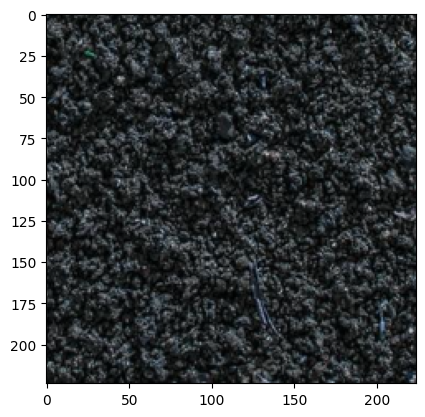

In [33]:
image = load_and_preprocess_image("test_folder/black-soil-texture.png")
prediction = predict_image(soil_model, image)
print(class_names[np.argmax(prediction)])